In [112]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

In [113]:
df = pd.read_csv("/Users/neseuygun/Desktop/data/nyc_taxi.csv", index_col="timestamp", parse_dates=True)


In [114]:
df

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309


In [115]:
df.isnull().sum()

value    0
dtype: int64

## Outlier detection methods

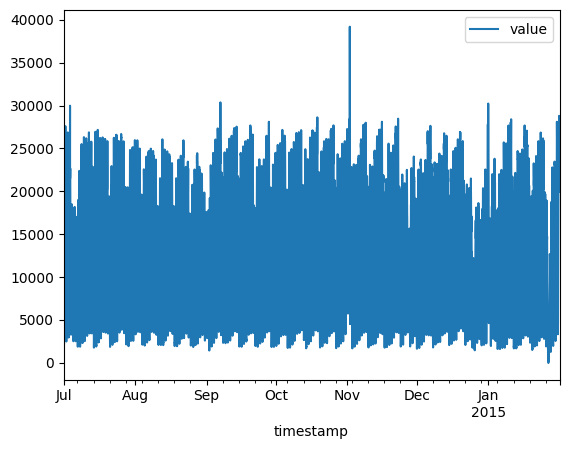

In [116]:
df.plot()
plt.show()

Our data consists of the days. so we need to observe the visualization of average daily values to be able to check outliers.

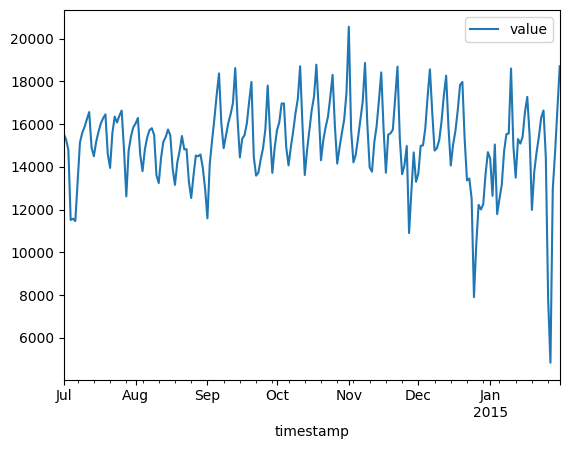

In [117]:
daily = df.resample("D").mean()
daily.plot()
plt.show()

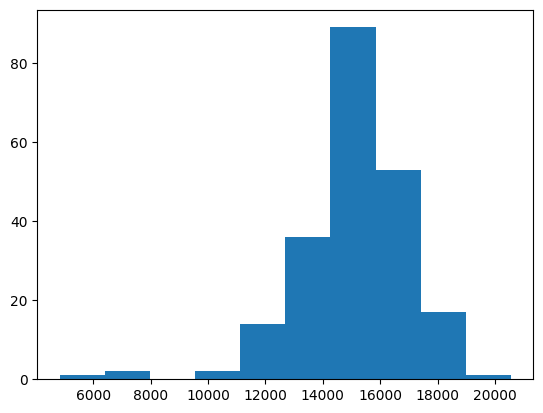

In [118]:
#The other visualization option of checking outlier points is histogram
plt.hist(daily)
plt.show()

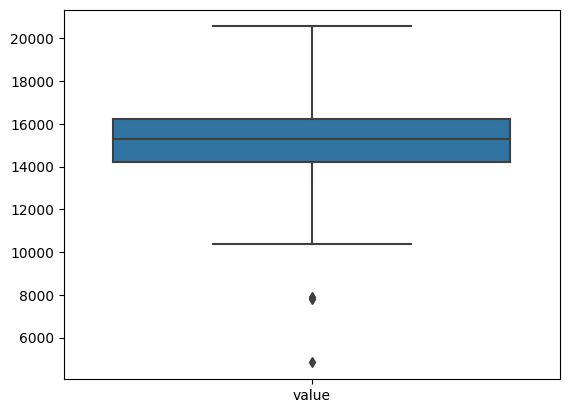

In [119]:
#checking outlier with boxplot
sns.boxplot(daily, whis=3) #default iqr value is 1.5 but I want to take extreme outlier values. that is why I use whis=3 parameter.
plt.show()

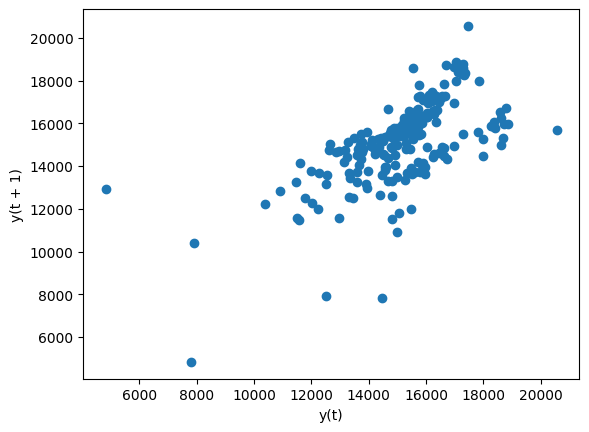

In [120]:
# we can check correlation distrubition of lag features with each other via using lag_plot to observe outlier.
from pandas.plotting import lag_plot
lag_plot(daily)
plt.show()


In [121]:
# writing a function that filters the outlier rows
def outlier_value(dataframe, iqrcoef=1.5):
    q1, q3 = np.percentile(dataframe, [25,75])
    IQR = q3-q1
    lower_limit = q1 - (iqrcoef*IQR)
    upper_limit = q3 + (iqrcoef*IQR)

    return dataframe[(dataframe.value < lower_limit) | (dataframe.value > upper_limit)]



In [122]:
outlier = outlier_value(daily)
outlier

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


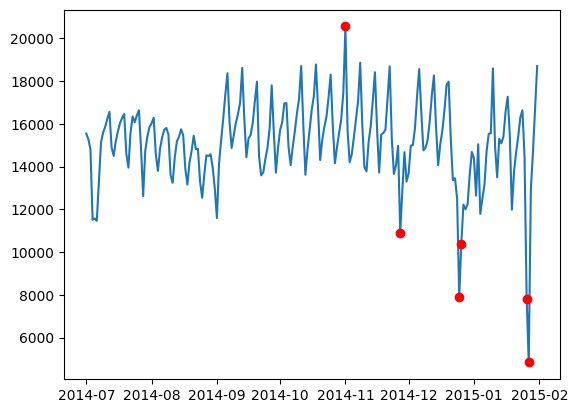

In [123]:
points = daily.loc[outlier["value"].index]
plt.plot(daily)
plt.plot(points, "ro")
plt.show()

In [124]:
outlier_with3 = outlier_value(daily, 3)
print(outlier_with3 )

                  value
timestamp              
2014-12-25  7902.125000
2015-01-26  7818.979167
2015-01-27  4834.541667


In [125]:
#checking outlier via z score 
def outlier_zscore(dataframe, st=3):
    dataframe["zscore"] = (dataframe - dataframe.mean())/dataframe.std()
    outlier = dataframe[(dataframe["zscore"] < -st) | (dataframe["zscore"] > st)]
    return outlier

In [126]:
outlier2 = outlier_zscore(daily)
outlier2

,value,zscore
timestamp,,
2014-12-25,7902.125000,-3.734633
2015-01-26,7818.979167,-3.777549
2015-01-27,4834.541667,-5.317991


In [127]:
# to be able to use z score for outlier we must check if out data has normal distribution.
from statsmodels.stats.diagnostic import kstest_normal
print(kstest_normal(daily["value"])) # p_value is lower than 0.05 so our data has not normal distribution

(0.0870330433299022, 0.0009999999999998899)


In [128]:
# let's take corrected z score and check the outlier with it
import scipy.stats as stats

def corrected_z_score(dataframe, col, st=3):
    s = stats.norm.ppf(0.75)
    x = s*(dataframe[col] - dataframe[col].median())
    y = np.abs(dataframe[col] - dataframe[col].median()).median()
    dataframe["corrected_z_score"] = x/y
    outlier = dataframe[(dataframe["corrected_z_score"] < -st) | (dataframe["corrected_z_score"] > st)]
    return outlier

outlier3 = corrected_z_score(daily, "value")
outlier3

,value,zscore,corrected_z_score
timestamp,,,
2014-11-01,20553.500000,2.795476,3.735461
2014-11-27,10899.666667,-2.187428,-3.128742
2014-12-25,7902.125000,-3.734633,-5.260096
2014-12-26,10397.958333,-2.446388,-3.485474
2015-01-26,7818.979167,-3.777549,-5.319215
2015-01-27,4834.541667,-5.317991,-7.441252


In [129]:
print(outlier)
print(outlier2)
print(outlier3)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
                  value    zscore
timestamp                        
2014-12-25  7902.125000 -3.734633
2015-01-26  7818.979167 -3.777549
2015-01-27  4834.541667 -5.317991
                   value    zscore  corrected_z_score
timestamp                                            
2014-11-01  20553.500000  2.795476           3.735461
2014-11-27  10899.666667 -2.187428          -3.128742
2014-12-25   7902.125000 -3.734633          -5.260096
2014-12-26  10397.958333 -2.446388          -3.485474
2015-01-26   7818.979167 -3.777549          -5.319215
2015-01-27   4834.541667 -5.317991          -7.441252


## Handling with outliers

In [130]:
# 1. Drop methods
print(daily)
firstmethod = daily.drop(outlier["value"].index)
print(firstmethod)

                   value    zscore  corrected_z_score
timestamp                                            
2014-07-01  15540.979167  0.208223           0.171389
2014-07-02  15284.166667  0.075667          -0.011214
2014-07-03  14794.625000 -0.177014          -0.359294
2014-07-04  11511.770833 -1.871485          -2.693515
2014-07-05  11572.291667 -1.840247          -2.650483
...                  ...       ...                ...
2015-01-27   4834.541667 -5.317991          -7.441252
2015-01-28  12947.562500 -1.130390          -1.672618
2015-01-29  14686.145833 -0.233006          -0.436427
2015-01-30  16676.625000  0.794396           0.978872
2015-01-31  18702.479167  1.840057           2.419323

[215 rows x 3 columns]
                   value    zscore  corrected_z_score
timestamp                                            
2014-07-01  15540.979167  0.208223           0.171389
2014-07-02  15284.166667  0.075667          -0.011214
2014-07-03  14794.625000 -0.177014          -0.359294
2014

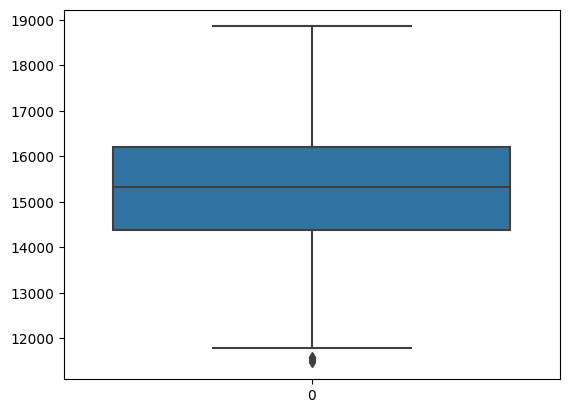

In [131]:
#check boxplot after removing outliers
sns.boxplot(firstmethod["value"])
plt.show()

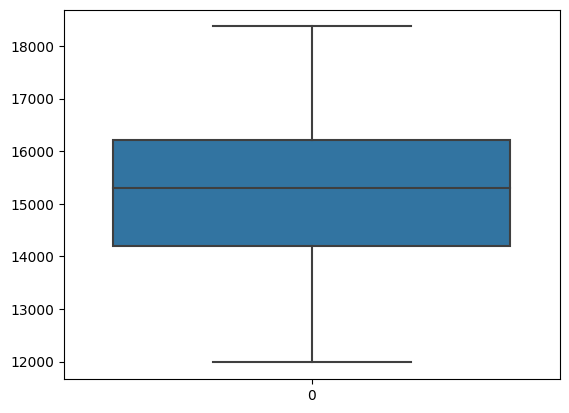

In [132]:
#2. winsorize method
from scipy.stats.mstats import winsorize
daily["value2"] = winsorize(daily["value"], (0.05,0.05))

sns.boxplot(daily["value2"])
plt.show()

In [133]:
#3. Interpolation method. 
#firstly we should convert outliers into nan values
daily_data = daily[["value"]]
daily_data.loc[outlier["value"].index,:] = np.nan
daily_data

/var/folders/hq/f4fnfxxj0psb8f_l4kc58_tr0000gn/T/ipykernel_10717/1384500997.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data.loc[outlier["value"].index,:] = np.nan


,value
timestamp,
2014-07-01,15540.979167
2014-07-02,15284.166667
2014-07-03,14794.625000
2014-07-04,11511.770833
2014-07-05,11572.291667
...,...
2015-01-27,NaN
2015-01-28,12947.562500
2015-01-29,14686.145833


<function matplotlib.pyplot.show(close=None, block=None)>

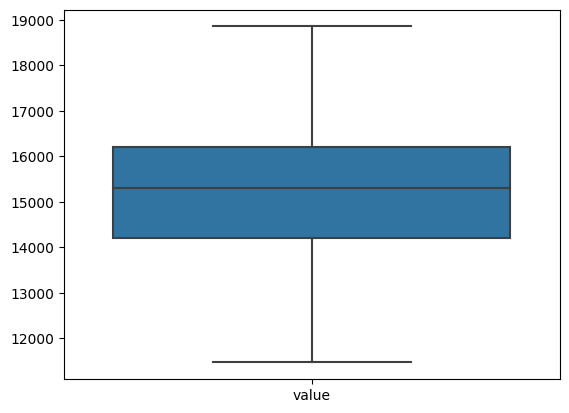

In [134]:
daily_data = daily_data.interpolate()

sns.boxplot(daily_data)
plt.show